# Setup

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [2]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
#data = pd.read_csv('data/all_annotations.tsv', sep='\t')
data = pd.read_csv('data/updated_chords.csv')

#Get a list of the chords that appear more than once
chord_dist = data[['chord']].groupby('chord')[['chord']].count()
common = chord_dist[chord_dist[['chord']] > 1].dropna().index.values

#Remove rare chords
data = data[data.chord.isin(common)]

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Only keep the chords???
tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Data exploration

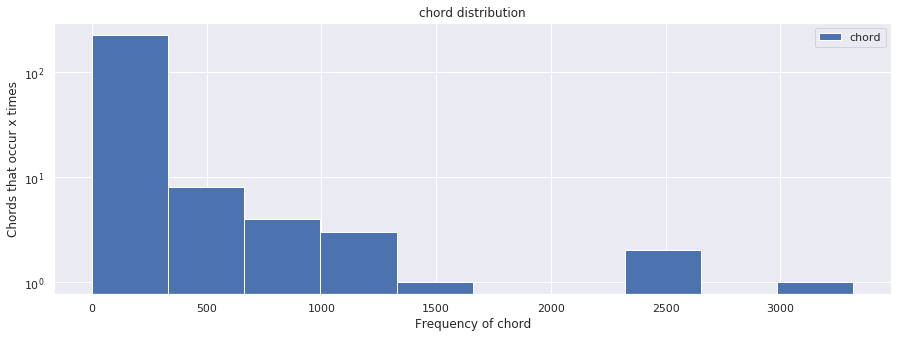

In [3]:
#Count how many times each chord appear
chord_dist = data[['chord']].groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("chord distribution")


# Helper Functions

In [4]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(model.summary())
    plt.show()

In [5]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing with long sequence lengths.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y

# Models

In [6]:
def sequential(classes, features, optimizer, loss, metrics):
    """
    A sequential neural network. You train on features until you learn to predict a chord from its corresponding features.
    The kind of model we would have used if we wanted to predict to do chord classification.
    Just for testing purposes.
    """
    #Setup basic model
    model = tf.keras.Sequential()
    
    # Input layer. One node for each feature
    model.add(layers.Dense(256, input_dim = features, activation='relu'))
    
    # Hidden layer
    model.add(layers.Dense(256, activation='relu'))

    # Output layer. One node for each class
    model.add(layers.Dense(classes, activation='softmax'))

    #Compile the model with the chosen parameters
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics= metrics)
    return model

In [7]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('softmax')) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

# Train

## Setup

In [8]:
#Define parameters
classes = y.shape[1]
features = tx.shape[1]
optimizer = optimizers.RMSprop()
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Save the weights whenever we get a new best validation score in a file so we can restart from that point
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

#callbacks_list = [checkpoint]     
callbacks_list = []  

#Load previous weights
#model.load_weights('weights.10-4.13.hdf5')

## Fit

In [9]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 5)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h1 = history

Train on 20154 samples, validate on 5039 samples
Epoch 1/30
 - 114s - loss: 5.0927 - acc: 0.1233 - val_loss: 4.7815 - val_acc: 0.0949
Epoch 2/30
 - 109s - loss: 4.5186 - acc: 0.1255 - val_loss: 4.3168 - val_acc: 0.0949
Epoch 3/30
 - 119s - loss: 4.1177 - acc: 0.1256 - val_loss: 4.0135 - val_acc: 0.0949
Epoch 4/30
 - 115s - loss: 3.8682 - acc: 0.1257 - val_loss: 3.8690 - val_acc: 0.0949
Epoch 5/30
 - 119s - loss: 3.7509 - acc: 0.1257 - val_loss: 3.8175 - val_acc: 0.0949
Epoch 6/30
 - 119s - loss: 3.7042 - acc: 0.1257 - val_loss: 3.7999 - val_acc: 0.0949
Epoch 7/30
 - 115s - loss: 3.6851 - acc: 0.1257 - val_loss: 3.7938 - val_acc: 0.0949
Epoch 8/30
 - 109s - loss: 3.6776 - acc: 0.1257 - val_loss: 3.7942 - val_acc: 0.0949
Epoch 9/30
 - 109s - loss: 3.6756 - acc: 0.1257 - val_loss: 3.7962 - val_acc: 0.0949
Epoch 10/30
 - 109s - loss: 3.6761 - acc: 0.1257 - val_loss: 3.8026 - val_acc: 0.0949
Epoch 11/30
 - 109s - loss: 3.6796 - acc: 0.1257 - val_loss: 3.8055 - val_acc: 0.0949
Epoch 12/30
 -

In [10]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h2 = history

Train on 20150 samples, validate on 5038 samples
Epoch 1/30
 - 213s - loss: 5.1008 - acc: 0.0951 - val_loss: 4.7927 - val_acc: 0.0947
Epoch 2/30
 - 210s - loss: 4.5262 - acc: 0.1254 - val_loss: 4.3188 - val_acc: 0.0949
Epoch 3/30
 - 210s - loss: 4.1235 - acc: 0.1256 - val_loss: 4.0264 - val_acc: 0.0949
Epoch 4/30
 - 210s - loss: 3.8793 - acc: 0.1257 - val_loss: 3.8756 - val_acc: 0.0949
Epoch 5/30
 - 210s - loss: 3.7573 - acc: 0.1258 - val_loss: 3.8196 - val_acc: 0.0949
Epoch 6/30
 - 231s - loss: 3.7034 - acc: 0.1258 - val_loss: 3.7977 - val_acc: 0.0949
Epoch 7/30
 - 226s - loss: 3.6828 - acc: 0.1258 - val_loss: 3.7959 - val_acc: 0.0949
Epoch 8/30
 - 211s - loss: 3.6735 - acc: 0.1258 - val_loss: 3.7940 - val_acc: 0.0949
Epoch 9/30
 - 210s - loss: 3.6699 - acc: 0.1258 - val_loss: 3.7838 - val_acc: 0.0949
Epoch 10/30
 - 226s - loss: 3.6590 - acc: 0.1258 - val_loss: 3.7917 - val_acc: 0.0949
Epoch 11/30
 - 224s - loss: 3.6541 - acc: 0.1258 - val_loss: 3.7363 - val_acc: 0.0949
Epoch 12/30
 -

In [11]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 20)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h3 = history

Train on 20142 samples, validate on 5036 samples
Epoch 1/30
 - 416s - loss: 5.0921 - acc: 0.1065 - val_loss: 4.7808 - val_acc: 0.0947
Epoch 2/30
 - 411s - loss: 4.5104 - acc: 0.1249 - val_loss: 4.3026 - val_acc: 0.0947
Epoch 3/30
 - 411s - loss: 4.1060 - acc: 0.1258 - val_loss: 4.0091 - val_acc: 0.0947
Epoch 4/30
 - 411s - loss: 3.8678 - acc: 0.1259 - val_loss: 3.8669 - val_acc: 0.0947
Epoch 5/30
 - 412s - loss: 3.7515 - acc: 0.1259 - val_loss: 3.8151 - val_acc: 0.0947
Epoch 6/30
 - 412s - loss: 3.7033 - acc: 0.1259 - val_loss: 3.7974 - val_acc: 0.0947
Epoch 7/30
 - 411s - loss: 3.6841 - acc: 0.1259 - val_loss: 3.7924 - val_acc: 0.0947
Epoch 8/30
 - 411s - loss: 3.6768 - acc: 0.1259 - val_loss: 3.7940 - val_acc: 0.0947
Epoch 9/30
 - 412s - loss: 3.6757 - acc: 0.1259 - val_loss: 3.8026 - val_acc: 0.0947
Epoch 10/30
 - 412s - loss: 3.6822 - acc: 0.1259 - val_loss: 3.8057 - val_acc: 0.0947
Epoch 11/30
 - 412s - loss: 3.6797 - acc: 0.1259 - val_loss: 3.8098 - val_acc: 0.0947
Epoch 12/30
 -

In [12]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 40)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h4 = history

Train on 20126 samples, validate on 5032 samples
Epoch 1/30
 - 820s - loss: 5.0925 - acc: 0.0868 - val_loss: 4.7770 - val_acc: 0.1095
Epoch 2/30
 - 815s - loss: 4.5123 - acc: 0.1128 - val_loss: 4.2998 - val_acc: 0.0948
Epoch 3/30
 - 815s - loss: 4.1090 - acc: 0.1258 - val_loss: 4.0074 - val_acc: 0.0948
Epoch 4/30
 - 846s - loss: 3.8688 - acc: 0.1260 - val_loss: 3.8651 - val_acc: 0.0948
Epoch 5/30
 - 810s - loss: 3.7529 - acc: 0.1260 - val_loss: 3.8136 - val_acc: 0.0948
Epoch 6/30
 - 853s - loss: 3.7035 - acc: 0.1260 - val_loss: 3.7972 - val_acc: 0.0948
Epoch 7/30
 - 821s - loss: 3.6843 - acc: 0.1260 - val_loss: 3.7910 - val_acc: 0.0948
Epoch 8/30
 - 803s - loss: 3.6761 - acc: 0.1260 - val_loss: 3.7924 - val_acc: 0.0948
Epoch 9/30
 - 794s - loss: 3.6745 - acc: 0.1260 - val_loss: 3.7948 - val_acc: 0.0948
Epoch 10/30
 - 796s - loss: 3.6762 - acc: 0.1260 - val_loss: 3.7986 - val_acc: 0.0948
Epoch 11/30
 - 793s - loss: 3.6781 - acc: 0.1260 - val_loss: 3.8042 - val_acc: 0.0948
Epoch 12/30
 -

In [13]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 80)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h5 = history

Train on 20094 samples, validate on 5024 samples
Epoch 1/30
 - 1638s - loss: 5.0968 - acc: 0.1062 - val_loss: 4.7845 - val_acc: 0.0949
Epoch 2/30
 - 1621s - loss: 4.5163 - acc: 0.1259 - val_loss: 4.3057 - val_acc: 0.0949
Epoch 3/30
 - 1635s - loss: 4.1101 - acc: 0.1259 - val_loss: 4.0101 - val_acc: 0.0949
Epoch 4/30
 - 1614s - loss: 3.8701 - acc: 0.1259 - val_loss: 3.8660 - val_acc: 0.0949
Epoch 5/30
 - 1611s - loss: 3.7529 - acc: 0.1259 - val_loss: 3.8140 - val_acc: 0.0949
Epoch 6/30
 - 1611s - loss: 3.7035 - acc: 0.1259 - val_loss: 3.7976 - val_acc: 0.0949
Epoch 7/30
 - 1611s - loss: 3.6847 - acc: 0.1259 - val_loss: 3.7934 - val_acc: 0.0949
Epoch 8/30
 - 1612s - loss: 3.6768 - acc: 0.1259 - val_loss: 3.7930 - val_acc: 0.0949
Epoch 9/30
 - 1612s - loss: 3.6738 - acc: 0.1259 - val_loss: 3.7963 - val_acc: 0.0949
Epoch 10/30
 - 1612s - loss: 3.6747 - acc: 0.1259 - val_loss: 3.7999 - val_acc: 0.0949
Epoch 11/30
 - 1612s - loss: 3.6779 - acc: 0.1259 - val_loss: 3.8045 - val_acc: 0.0949
Epo

In [14]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 160)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 2,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h6 = history

Train on 20030 samples, validate on 5008 samples
Epoch 1/30
 - 3314s - loss: 5.1013 - acc: 0.0814 - val_loss: 4.7850 - val_acc: 0.1096
Epoch 2/30
 - 3333s - loss: 4.5204 - acc: 0.1220 - val_loss: 4.3069 - val_acc: 0.0952
Epoch 3/30


KeyboardInterrupt: 

# Results

Final values
acc
0.18487645131149047
valacc
0.1522127405980036
loss
3.2899261492638048
valoss
3.598195571846422

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

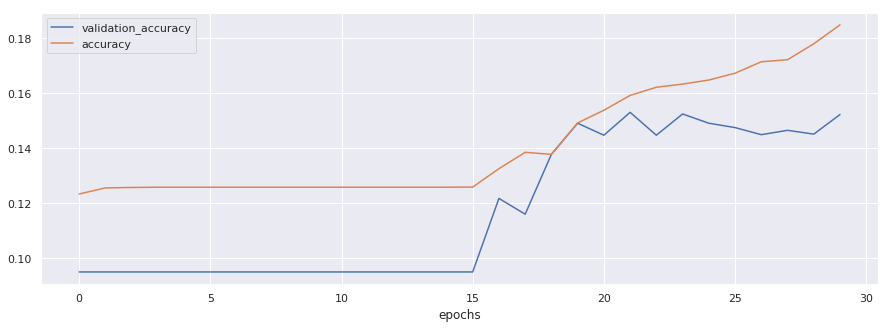

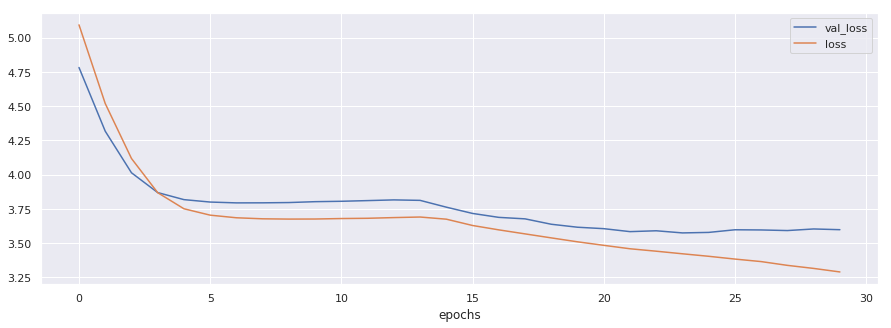

Final values
acc
0.21727047144922962
valacc
0.15839618893133928
loss
3.141557002150391
valoss
3.5978817542236254

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

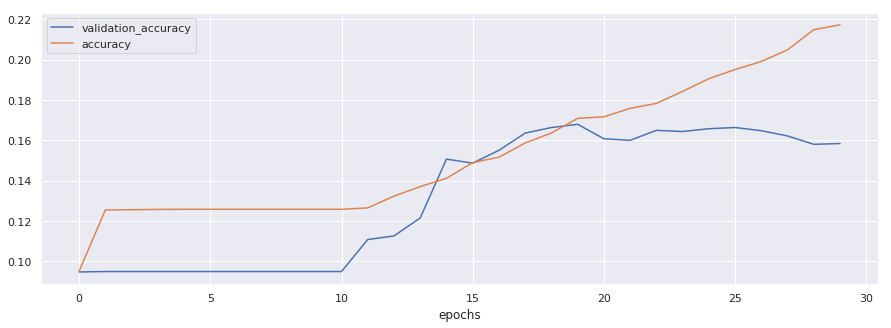

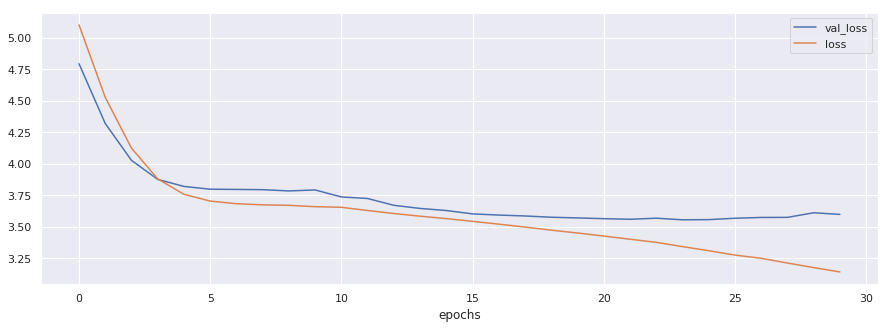

Final values
acc
0.16413464401260933
valacc
0.15031771248796802
loss
3.4155722475255472
valoss
3.5944106556102335

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
___________________________

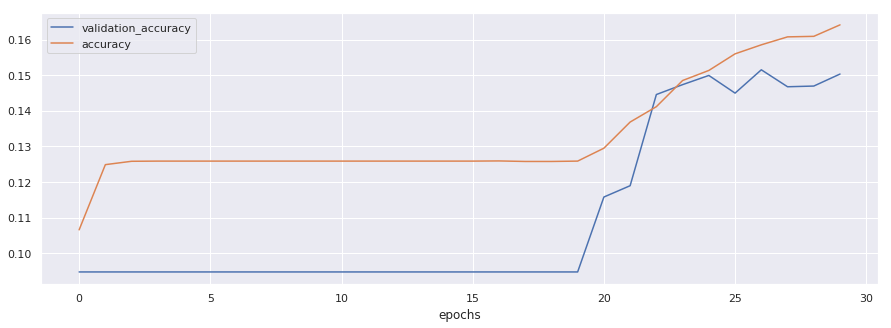

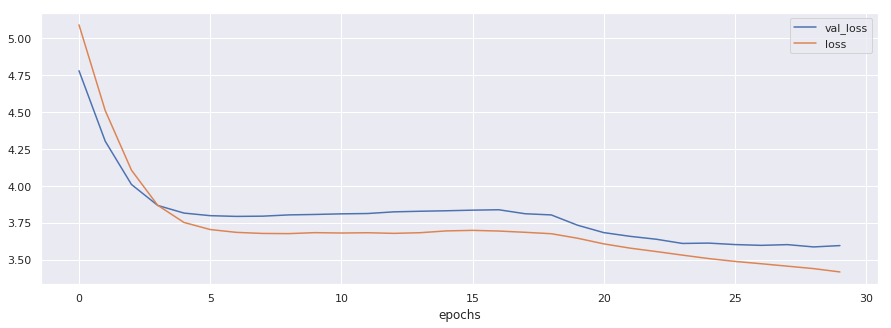

Final values
acc
0.18761800656312266
valacc
0.15441176470588236
loss
3.345946513408815
valoss
3.6128885901410173

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

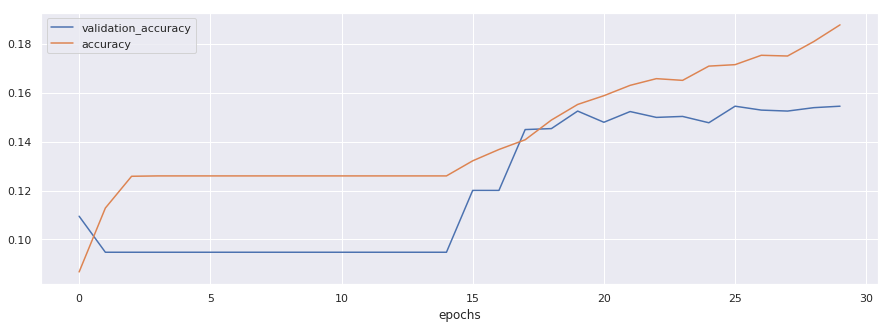

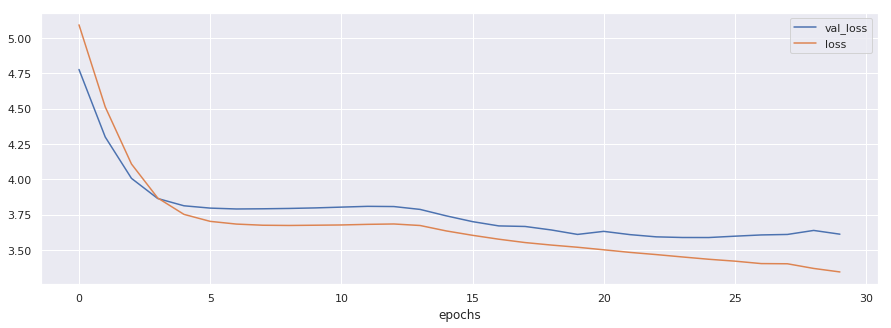

Final values
acc
0.14904946749235512
valacc
0.1429140127388535
loss
3.556054708363702
valoss
3.6760981447377783

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

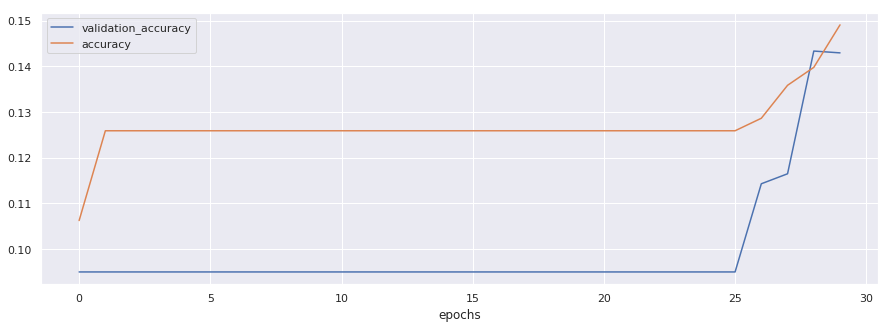

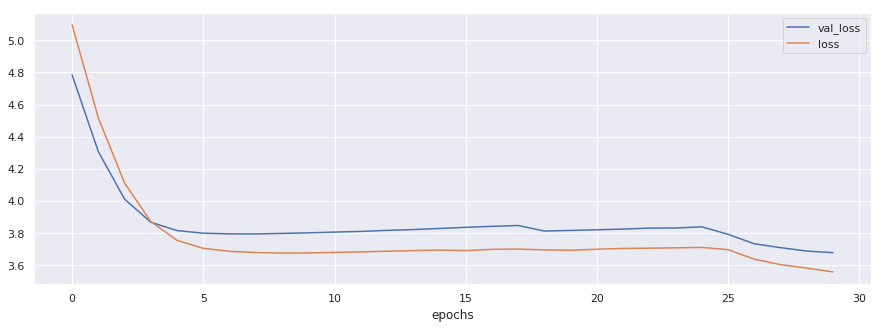

In [15]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)
#disp_results(h6)